In [1]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [2]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

import itertools

import scipy.stats as stats

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [4]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [5]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

In [6]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,sd,num_local_peaks
308,195_flipped,2017.11.23,7200,25.20 s.tifheightmap.mat,17.581478,9523,69795.393949,0.695667,1,0.529056,7.329139,[[9.52300000e+03 6.28924000e+05 5.05009060e+07...,0.600172,523.161472,[[1187.44799186 316.73756634]\r\n [ 316.73756...,0,1,4.042945,9
63,63,2017.11.17,7200,23.85 s.tifheightmap.mat,9.828685,24893,115363.780955,0.770033,1,0.171501,4.634386,[[2.48930000e+04 6.93627900e+06 2.44826161e+09...,-1.525484,1809.408296,[[ 8465.11099674 -556.32201514]\r\n [ -556.32...,0,3,1.883517,31
72,72,2017.11.17,7200,5.20 s.tifheightmap.mat,6.577711,8005,12404.227215,0.999753,1,0.537934,1.549560,[[8.00500000e+03 2.60840000e+06 1.17772984e+09...,-1.569433,1380.818326,[[ 2.02879511e+01 -5.57794988e+01]\r\n [-5.577...,1,1,0.930417,3
233,127_flipped,2017.11.22,7200,73.60 s.tifheightmap.mat,11.304808,6486,37320.895477,0.899984,1,0.504276,5.754070,[[6.48600000e+03 4.28188000e+05 3.24840560e+07...,0.632162,396.090404,[[986.01363778 530.83653442]\r\n [530.83653442...,0,1,3.298348,5
114,114,2017.11.22,7200,18.60 s.tifheightmap.mat,11.334184,1130,6963.694939,0.870604,1,0.536562,6.162562,[[1.13000000e+03 2.75390000e+04 8.67535000e+05...,1.177133,153.195959,[[ 69.16028272 52.51918318]\r\n [ 52.51918318...,0,1,3.497418,2


### Downsample to balanced classes

In [7]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('flow_rate').size())

flow_rate
1800    116
3600    116
7200    116
dtype: int64


### Drop columns which we aren't using as features

In [8]:
def drop_cols(df):
    return df.drop(columns=['name','date','flow_rate','source','moments',
                            'inertia_tensor','euler_number','num_peaks','cluster']).as_matrix()

In [9]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical  features
mat = x.drop(columns=['euler_number', 'num_peaks', 'cluster'])

x = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

### Ignore this block

In [10]:
test_size = int(df.shape[0]/10)

x_test = np.array(x[:test_size])
y_test = df['flow_rate'][:test_size].values

x_train = np.array(x[test_size:])
y_train = df['flow_rate'][test_size:].values

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

### Split data into balanced test and training sets

In [11]:
x_test = pd.concat([df[df['flow_rate']==i].sample(n=10) for i in (1800,3600,7200)],ignore_index=True)
y_test = x_test['flow_rate'].values

x_train = pd.concat([df, x_test, x_test]).drop_duplicates(keep=False)
y_train = x_train['flow_rate'].values

x_test = drop_cols(x_test)
x_train = drop_cols(x_train)

print(x_train.shape)
print(x_test.shape)

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

(318, 11)
(30, 11)


## Run Logistic Regression

In [12]:
batch_size = 16
nb_classes = 3
nb_epoch = 30

lmda = 0.001

In [13]:
input_dim = x_train.shape[1]

In [14]:
y_train[y_train == 1800] = 0
y_train[y_train == 3600] = 1
y_train[y_train == 7200] = 2

y_test[y_test == 1800] = 0
y_test[y_test == 3600] = 1
y_test[y_test == 7200] = 2

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [15]:
def build_logistic_model(input_dim, output_dim, lmda):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))
    
    return model

def compile_model(input_dim, output_dim, lmda, optimizer):
    model = build_logistic_model(input_dim,output_dim,lmda)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
model = None
model = build_logistic_model(input_dim, nb_classes,lmda)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 36        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [18]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 318 samples, validate on 30 samples
Epoch 1/30
318/318 [==============================] - 2s 8ms/step - loss: 1.6713 - acc: 0.3113 - val_loss: 1.3243 - val_acc: 0.3667
Epoch 2/30
318/318 [==============================] - 0s 295us/step - loss: 1.5720 - acc: 0.3270 - val_loss: 1.2829 - val_acc: 0.3667
Epoch 3/30
318/318 [==============================] - 0s 295us/step - loss: 1.4888 - acc: 0.3365 - val_loss: 1.2516 - val_acc: 0.3667
Epoch 4/30
318/318 [==============================] - 0s 295us/step - loss: 1.4219 - acc: 0.3365 - val_loss: 1.2282 - val_acc: 0.3000
Epoch 5/30
318/318 [==============================] - 0s 246us/step - loss: 1.3661 - acc: 0.3270 - val_loss: 1.2114 - val_acc: 0.3000
Epoch 6/30
318/318 [==============================] - 0s 344us/step - loss: 1.3200 - acc: 0.3208 - val_loss: 1.1997 - val_acc: 0.3000
Epoch 7/30
318/318 [==============================] - 0s 246us/step - loss: 1.2841 - acc: 0.3208 - val_loss: 1.1915 - val_acc: 0.3000
Epoch 8/30
318/318 

In [19]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.138628363609314
Test accuracy: 0.3333333432674408


## Confusion Matrix

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

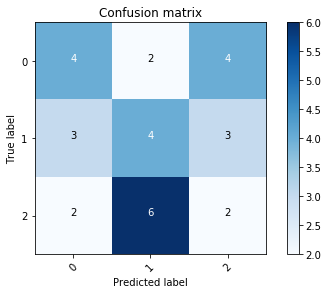

In [21]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## LR With Cross Validation

In [22]:
batch_size = 8
nb_classes = 3
lmda = 0.01

nb_epoch = 10

In [23]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    return score[1]

In [24]:
n_folds = 10

labels = df['flow_rate'].values
data = x

labels[labels == 1800] = 0
labels[labels == 3600] = 1
labels[labels == 7200] = 2

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['flow_rate'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes, lmda)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 312 samples, validate on 36 samples
Epoch 1/10
312/312 [==============================] - 0s 1ms/step - loss: 1.4369 - acc: 0.3109 - val_loss: 1.4646 - val_acc: 0.2778
Epoch 2/10
312/312 [==============================] - 0s 701us/step - loss: 1.3293 - acc: 0.3397 - val_loss: 1.4091 - val_acc: 0.2500
Epoch 3/10
312/312 [==============================] - 0s 701us/step - loss: 1.2625 - acc: 0.3590 - val_loss: 1.3703 - val_acc: 0.2222
Epoch 4/10
312/312 [==============================] - 0s 701us/step - loss: 1.2187 - acc: 0.3782 - val_loss: 1.3410 - val_acc: 0.2778
Epoch 5/10
312/312 [==============================] - 0s 651us/step - loss: 1.1881 - acc: 0.4038 - val_loss: 1.3169 - val_acc: 0.2778
Epoch 6/10
312/312 [==============================] - 0s 601us/step - loss: 1.1661 - acc: 0.4071 - val_loss: 1.2976 - val_acc: 0.3056
Epoch 7/10
312/312 [==============================] - 0s 651us/step - loss: 1.1488 - acc: 0.3974 - val_loss: 1.2818 - val_acc: 0.3333

312/312 [==============================] - 0s 601us/step - loss: 1.1226 - acc: 0.3686 - val_loss: 1.1976 - val_acc: 0.3333
Epoch 10/10
312/312 [==============================] - 0s 501us/step - loss: 1.1155 - acc: 0.3590 - val_loss: 1.1913 - val_acc: 0.3333
Running Fold 7 / 10
Train on 315 samples, validate on 33 samples
Epoch 1/10
315/315 [==============================] - 0s 1ms/step - loss: 1.8397 - acc: 0.3111 - val_loss: 1.2502 - val_acc: 0.4242
Epoch 2/10
315/315 [==============================] - 0s 595us/step - loss: 1.5819 - acc: 0.2921 - val_loss: 1.1614 - val_acc: 0.4545
Epoch 3/10
315/315 [==============================] - 0s 794us/step - loss: 1.4061 - acc: 0.3270 - val_loss: 1.1129 - val_acc: 0.4545
Epoch 4/10
315/315 [==============================] - 0s 595us/step - loss: 1.2910 - acc: 0.3365 - val_loss: 1.0942 - val_acc: 0.4545
Epoch 5/10
315/315 [==============================] - 0s 546us/step - loss: 1.2249 - acc: 0.3524 - val_loss: 1.0885 - val_acc: 0.4242
Epoch 6/1

In [25]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.37272727272727274


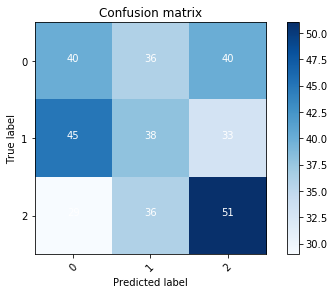

In [26]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## Grid Search on Hyper-parameters

Note: Test dataset size is wrong?

Also: This takes a while!

In [ ]:
model = KerasClassifier(build_fn=compile_model,input_dim=input_dim, output_dim=nb_classes, optimizer='sgd')

param_grid = dict(epochs=[10,20,30], batch_size=[4,8,16,32], lmda=[0.001,0.005,0.01,0.05,0.1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)
grid_result = grid.fit(data, one_hot)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 11.1792 - acc: 0.3067
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1792 - acc: 0.3067
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1792 - acc: 0.3067
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1791 - acc: 0.3067
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1791 - acc: 0.3067
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1791 - acc: 0.3067
Epoch 7/10
313/313 [==============================] - 0s 2ms/step - loss: 11.1791 - acc: 0.3067
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 11.1791 - acc: 0.3067
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1791 - acc: 0.3067
Ep

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


313/313 [==============================] - 1s 2ms/step - loss: 10.7672 - acc: 0.3323
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3323
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7670 - acc: 0.3323
Epoch 10/10
313/313 [==============================] - 0s 849us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   4.5s
[CV] ba

313/313 [==============================] - 0s 799us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   4.2s
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
314/314 [==============================] - 1s 2ms/step - loss: 10.7837 - acc: 0.3312
Epoch 2/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7836 - acc: 0.3312
Epoch 3/10
314/314 [==============================] - 0s 896us/step - loss: 10.7836 - acc: 0.3312
Epoch 4/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7836 - acc: 0.3312
Epoch 5/10
314/314 [==============================] - 0s 995us/step - loss: 10.7836 - acc: 0.3312
Epoch 6/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7836 - acc: 0.3312
Epoch 7/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7836 - acc: 0.3312
Epoch 8/10
314/314 [==============================] - 0s 945us/step - loss: 10.7836 - acc: 0.3312
Epoch 9/10
314/314 [=======

313/313 [==============================] - 0s 1ms/step - loss: 10.8334 - acc: 0.3291
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 10.8331 - acc: 0.3291
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 10.8328 - acc: 0.3291
Epoch 9/10
313/313 [==============================] - 0s 998us/step - loss: 10.8325 - acc: 0.3291
Epoch 10/10
313/313 [==============================] - 0s 1ms/step
[CV] .............. batch_size=4, epochs=10, lmda=0.005, total=   4.6s
[CV] batch_size=4, epochs=10, lmda=0.005 .............................
Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 10.9372 - acc: 0.3227
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 10.9368 - acc: 0.3227
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 10.9365 - acc: 0.3227
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 10.9362 - acc: 0.3227
Epoch 5/10
313/313 [============

Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 10.7506 - acc: 0.3355
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7494 - acc: 0.3355
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 10.7482 - acc: 0.3355
Epoch 6/10
313/313 [==============================] - 0s 2ms/step - loss: 10.7470 - acc: 0.3355
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7459 - acc: 0.3355
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 10.7448 - acc: 0.3355
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7438 - acc: 0.3355
Epoch 10/10
313/313 [==============================] - 0s 599us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   5.7s
[CV] batch_size=4, epochs=10, lmda=0.01 ..............................
Epoch 1/10
313/313 [==============================] - 1s 4ms/step - loss: 10.9153 - acc: 0.3259
Epoch 2/10
313/313 [=

Epoch 1/10
314/314 [==============================] - 1s 4ms/step - loss: 10.6754 - acc: 0.3408
Epoch 2/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6739 - acc: 0.3408
Epoch 3/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6724 - acc: 0.3408
Epoch 4/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6709 - acc: 0.3408
Epoch 5/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6695 - acc: 0.3408
Epoch 6/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6681 - acc: 0.3408
Epoch 7/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6668 - acc: 0.3408
Epoch 8/10
314/314 [==============================] - 0s 2ms/step - loss: 10.6655 - acc: 0.3408
Epoch 9/10
314/314 [==============================] - 0s 1ms/step - loss: 10.6643 - acc: 0.3408
Epoch 10/10
314/314 [==============================] - 0s 498us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   5

313/313 [==============================] - 0s 499us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.05, total=   5.9s
[CV] batch_size=4, epochs=10, lmda=0.05 ..............................
Epoch 1/10
313/313 [==============================] - 1s 4ms/step - loss: 131.3613 - acc: 0.3642
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 136.0794 - acc: 0.3546
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 117.7032 - acc: 0.3546
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 102.0139 - acc: 0.3546
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 88.6186 - acc: 0.3546
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 77.1819 - acc: 0.3546
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 67.4175 - acc: 0.3546
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 59.0809 - acc: 0.3546
Epoch 9/10
313/313 [=========

313/313 [==============================] - 0s 2ms/step - loss: 10.7959 - acc: 0.3355
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7729 - acc: 0.3355
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7562 - acc: 0.3355
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7439 - acc: 0.3355
Epoch 10/10
313/313 [==============================] - 0s 563us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   5.9s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
313/313 [==============================] - 1s 5ms/step - loss: 11.3042 - acc: 0.3259
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1852 - acc: 0.3259
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 11.0985 - acc: 0.3259
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 11.0354 - acc: 0.3259
Epoch 5/10
313/313 [============

314/314 [==============================] - 0s 2ms/step - loss: 11.0308 - acc: 0.3344
Epoch 3/10
314/314 [==============================] - 1s 2ms/step - loss: 10.9488 - acc: 0.3344
Epoch 4/10
314/314 [==============================] - 0s 2ms/step - loss: 10.8890 - acc: 0.3344
Epoch 5/10
314/314 [==============================] - 0s 2ms/step - loss: 10.8454 - acc: 0.3344
Epoch 6/10
314/314 [==============================] - 0s 1ms/step - loss: 10.8136 - acc: 0.3344
Epoch 7/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7905 - acc: 0.3344
Epoch 8/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7736 - acc: 0.3344
Epoch 9/10
314/314 [==============================] - 0s 1ms/step - loss: 10.7613 - acc: 0.3344
Epoch 10/10
314/314 [==============================] - 0s 647us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   6.4s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
314/314 [============

313/313 [==============================] - 0s 1ms/step - loss: 10.7669 - acc: 0.3323
Epoch 17/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7668 - acc: 0.3323
Epoch 18/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7668 - acc: 0.3323
Epoch 19/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7668 - acc: 0.3323
Epoch 20/20
313/313 [==============================] - 0s 649us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.001, total=  10.7s
[CV] batch_size=4, epochs=20, lmda=0.001 .............................
Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 11.0239 - acc: 0.3163
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 11.0239 - acc: 0.3163
Epoch 3/20
313/313 [==============================] - 0s 2ms/step - loss: 11.0239 - acc: 0.3163
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 11.0239 - acc: 0.3163
Epoch 5/20
313/313 [=========

313/313 [==============================] - 0s 1ms/step - loss: 10.7151 - acc: 0.3355
Epoch 11/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7151 - acc: 0.3355
Epoch 12/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7151 - acc: 0.3355
Epoch 13/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7151 - acc: 0.3355
Epoch 14/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7150 - acc: 0.3355
Epoch 15/20
313/313 [==============================] - 0s 2ms/step - loss: 10.7150 - acc: 0.3355
Epoch 16/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7150 - acc: 0.3355
Epoch 17/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7150 - acc: 0.3355
Epoch 18/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7150 - acc: 0.3355
Epoch 19/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7150 - acc: 0.3355
Epoch 20/20
313/313 [=====================

313/313 [==============================] - 0s 1ms/step - loss: 10.7886 - acc: 0.3323
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7882 - acc: 0.3323
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7878 - acc: 0.3323
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 10.7874 - acc: 0.3323
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7870 - acc: 0.3323
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 10.7866 - acc: 0.3323
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7862 - acc: 0.3323
Epoch 11/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7858 - acc: 0.3323
Epoch 12/20
313/313 [==============================] - 0s 2ms/step - loss: 10.7855 - acc: 0.3323
Epoch 13/20
313/313 [==============================] - 0s 2ms/step - loss: 10.7851 - acc: 0.3323
Epoch 14/20
313/313 [==========================

313/313 [==============================] - 0s 699us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.005, total=  10.8s
[CV] batch_size=4, epochs=20, lmda=0.005 .............................
Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 10.7818 - acc: 0.3323
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7815 - acc: 0.3323
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7812 - acc: 0.3323
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 10.7810 - acc: 0.3323
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7807 - acc: 0.3323
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7804 - acc: 0.3323
Epoch 7/20
313/313 [==============================] - 0s 2ms/step - loss: 10.7801 - acc: 0.3323
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 10.7798 - acc: 0.3323
Epoch 9/20
313/313 [=============

313/313 [==============================] - 0s 1ms/step - loss: 10.8369 - acc: 0.3291
Epoch 15/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8366 - acc: 0.3291
Epoch 16/20
313/313 [==============================] - 0s 2ms/step - loss: 10.8362 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8359 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8355 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 2ms/step - loss: 10.8352 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 549us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.005, total=  11.4s
[CV] batch_size=4, epochs=20, lmda=0.005 .............................
Epoch 1/20
314/314 [==============================] - 2s 6ms/step - loss: 10.9069 - acc: 0.3248
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 10.9065 - acc: 0.3248
Epoch 3/20
314/314 [=======

313/313 [==============================] - 0s 1ms/step - loss: 10.8966 - acc: 0.3259
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8957 - acc: 0.3259
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8947 - acc: 0.3259
Epoch 11/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8938 - acc: 0.3259
Epoch 12/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8929 - acc: 0.3259
Epoch 13/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8921 - acc: 0.3259
Epoch 14/20
313/313 [==============================] - 0s 2ms/step - loss: 10.8913 - acc: 0.3259
Epoch 15/20
313/313 [==============================] - 0s 2ms/step - loss: 10.8905 - acc: 0.3259
Epoch 16/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8897 - acc: 0.3259
Epoch 17/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8889 - acc: 0.3259
Epoch 18/20
313/313 [======================

313/313 [==============================] - 0s 2ms/step - loss: 10.9169 - acc: 0.3259
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9153 - acc: 0.3259
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9138 - acc: 0.3259
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9123 - acc: 0.3259
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9108 - acc: 0.3259
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9094 - acc: 0.3259
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9080 - acc: 0.3259
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9067 - acc: 0.3259
Epoch 10/20
313/313 [==============================] - 0s 2ms/step - loss: 10.9054 - acc: 0.3259
Epoch 11/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9042 - acc: 0.3259
Epoch 12/20
313/313 [============================

314/314 [==============================] - 1s 2ms/step - loss: 10.8524 - acc: 0.3280
Epoch 20/20
314/314 [==============================] - 0s 448us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.01, total=  12.0s
[CV] batch_size=4, epochs=20, lmda=0.01 ..............................
Epoch 1/20
314/314 [==============================] - 2s 7ms/step - loss: 10.7737 - acc: 0.3344
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 10.7723 - acc: 0.3344
Epoch 3/20
314/314 [==============================] - 0s 1ms/step - loss: 10.7709 - acc: 0.3344
Epoch 4/20
314/314 [==============================] - 0s 2ms/step - loss: 10.7696 - acc: 0.3344
Epoch 5/20
314/314 [==============================] - 0s 1ms/step - loss: 10.7683 - acc: 0.3344
Epoch 6/20
314/314 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3344
Epoch 7/20
314/314 [==============================] - 0s 1ms/step - loss: 10.7659 - acc: 0.3344
Epoch 8/20
314/314 [============

313/313 [==============================] - 0s 1ms/step - loss: 16.2521 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 0s 2ms/step - loss: 42.1087 - acc: 0.3450
Epoch 15/20
313/313 [==============================] - 0s 1ms/step - loss: 37.4952 - acc: 0.3450
Epoch 16/20
313/313 [==============================] - 0s 2ms/step - loss: 33.5563 - acc: 0.3450
Epoch 17/20
313/313 [==============================] - 0s 1ms/step - loss: 30.1933 - acc: 0.3450
Epoch 18/20
313/313 [==============================] - 0s 1ms/step - loss: 27.3221 - acc: 0.3450
Epoch 19/20
313/313 [==============================] - 0s 1ms/step - loss: 24.8707 - acc: 0.3450
Epoch 20/20
313/313 [==============================] - 0s 499us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, total=  11.3s
[CV] batch_size=4, epochs=20, lmda=0.05 ..............................
Epoch 1/20
313/313 [==============================] - 2s 7ms/step - loss: 11.2392 - acc: 0.3163
Epoch 2/20
313/313 [======

313/313 [==============================] - 0s 2ms/step - loss: 10.9981 - acc: 0.3227
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9862 - acc: 0.3227
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9761 - acc: 0.3227
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9675 - acc: 0.3227
Epoch 11/20
313/313 [==============================] - 1s 2ms/step - loss: 10.9601 - acc: 0.3227
Epoch 12/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9538 - acc: 0.3227
Epoch 13/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9484 - acc: 0.3227
Epoch 14/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9438 - acc: 0.3227
Epoch 15/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9399 - acc: 0.3227
Epoch 16/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9366 - acc: 0.3227
Epoch 17/20
313/313 [=======================

313/313 [==============================] - 2s 7ms/step - loss: 11.2431 - acc: 0.3259
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 11.1408 - acc: 0.3259
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 11.0661 - acc: 0.3259
Epoch 4/20
313/313 [==============================] - 0s 2ms/step - loss: 11.0117 - acc: 0.3259
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9721 - acc: 0.3259
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 10.9432 - acc: 0.3259
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9221 - acc: 0.3259
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9068 - acc: 0.3259
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8956 - acc: 0.3259
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8875 - acc: 0.3259
Epoch 11/20
313/313 [=============================

313/313 [==============================] - 0s 1ms/step - loss: 12.4490 - acc: 0.3482
Epoch 19/20
313/313 [==============================] - 0s 1ms/step - loss: 11.9218 - acc: 0.3482
Epoch 20/20
313/313 [==============================] - 0s 449us/step
[CV] ................ batch_size=4, epochs=20, lmda=0.1, total=  11.9s
[CV] batch_size=4, epochs=20, lmda=0.1 ...............................
Epoch 1/20
313/313 [==============================] - 2s 7ms/step - loss: 10.9762 - acc: 0.3419
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8764 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8036 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 10.7506 - acc: 0.3419
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 10.7119 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 10.6838 - acc: 0.3419
Epoch 7/20
313/313 [===========

313/313 [==============================] - 0s 1ms/step - loss: 10.8272 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8236 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8210 - acc: 0.3291
Epoch 15/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8192 - acc: 0.3291
Epoch 16/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8178 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8168 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8160 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 1ms/step - loss: 11.6350 - acc: 0.3131
Epoch 20/20
313/313 [==============================] - 0s 549us/step
[CV] ................ batch_size=4, epochs=20, lmda=0.1, total=  12.1s
[CV] batch_size=4, epochs=20, lmda=0.1 ...............................
Epoch 1/20
314/314 [=====

313/313 [==============================] - 0s 1ms/step - loss: 10.8805 - acc: 0.3387
Epoch 30/30
313/313 [==============================] - 0s 649us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.001, total=  16.7s
[CV] batch_size=4, epochs=30, lmda=0.001 .............................
Epoch 1/30
313/313 [==============================] - 3s 8ms/step - loss: 10.8189 - acc: 0.3291
Epoch 2/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8189 - acc: 0.3291
Epoch 3/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8189 - acc: 0.3291
Epoch 4/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8189 - acc: 0.3291
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8189 - acc: 0.3291
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8189 - acc: 0.3291
Epoch 7/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8189 - acc: 0.3291
Epoch 8/30
313/313 [============

313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 17/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 18/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 19/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 20/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 21/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 22/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9730 - acc: 0.3195
Epoch 23/30
313/313 [==============================] - 0s 2ms/step - loss: 10.9730 - acc: 0.3195
Epoch 24/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9729 - acc: 0.3195
Epoch 25/30
313/313 [==============================] - 1s 2ms/step - loss: 10.9729 - acc: 0.3195
Epoch 26/30
313/313 [=====================

Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6138 - acc: 0.3419
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6138 - acc: 0.3419
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6138 - acc: 0.3419
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6138 - acc: 0.3419
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6137 - acc: 0.3419
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 10.6137 - acc: 0.3419
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 10.6137 - acc: 0.3419
Epoch 10/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6137 - acc: 0.3419
Epoch 11/30
313/313 [==============================] - 0s 2ms/step - loss: 10.6137 - acc: 0.3419
Epoch 12/30
313/313 [==============================] - 0s 1ms/step - loss: 10.6137 - acc: 0.3419
Epoch 13/30
313/313 [================

314/314 [==============================] - 0s 2ms/step - loss: 10.7847 - acc: 0.3312
Epoch 23/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7847 - acc: 0.3312
Epoch 24/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7847 - acc: 0.3312
Epoch 25/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7847 - acc: 0.3312
Epoch 26/30
314/314 [==============================] - 1s 2ms/step - loss: 10.7847 - acc: 0.3312
Epoch 27/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7847 - acc: 0.3312
Epoch 28/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7846 - acc: 0.3312
Epoch 29/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7846 - acc: 0.3312
Epoch 30/30
314/314 [==============================] - 0s 697us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.001, total=  17.3s
[CV] batch_size=4, epochs=30, lmda=0.001 .............................
Epoch 1/30
314/314 [=====

313/313 [==============================] - 0s 1ms/step - loss: 10.7778 - acc: 0.3387
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7759 - acc: 0.3387
Epoch 11/30
313/313 [==============================] - 1s 2ms/step - loss: 10.7741 - acc: 0.3387
Epoch 12/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7723 - acc: 0.3387
Epoch 13/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7705 - acc: 0.3387
Epoch 14/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7688 - acc: 0.3387
Epoch 15/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7671 - acc: 0.3387
Epoch 16/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7654 - acc: 0.3387
Epoch 17/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7637 - acc: 0.3387
Epoch 18/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7621 - acc: 0.3387
Epoch 19/30
313/313 [=====================

313/313 [==============================] - 0s 1ms/step - loss: 10.5240 - acc: 0.3482
Epoch 29/30
313/313 [==============================] - 0s 2ms/step - loss: 10.5237 - acc: 0.3482
Epoch 30/30
313/313 [==============================] - 0s 492us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.005, total=  18.3s
[CV] batch_size=4, epochs=30, lmda=0.005 .............................
Epoch 1/30
313/313 [==============================] - 3s 9ms/step - loss: 10.5779 - acc: 0.3450
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 10.5776 - acc: 0.3450
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 10.5773 - acc: 0.3450
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 10.5769 - acc: 0.3450
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 10.5766 - acc: 0.3450
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 10.5763 - acc: 0.3450
Epoch 7/30
313/313 [===========

313/313 [==============================] - 0s 1ms/step - loss: 10.8258 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8256 - acc: 0.3291
Epoch 17/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8254 - acc: 0.3291
Epoch 18/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8253 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8251 - acc: 0.3291
Epoch 20/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8249 - acc: 0.3291
Epoch 21/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8247 - acc: 0.3291
Epoch 22/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8246 - acc: 0.3291
Epoch 23/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8244 - acc: 0.3291
Epoch 24/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8242 - acc: 0.3291
Epoch 25/30
313/313 [=====================

314/314 [==============================] - 3s 9ms/step - loss: 10.7525 - acc: 0.3344
Epoch 2/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7521 - acc: 0.3344
Epoch 3/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7517 - acc: 0.3344
Epoch 4/30
314/314 [==============================] - 0s 2ms/step - loss: 10.7514 - acc: 0.3344
Epoch 5/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7510 - acc: 0.3344
Epoch 6/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7507 - acc: 0.3344
Epoch 7/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7503 - acc: 0.3344
Epoch 8/30
314/314 [==============================] - 1s 2ms/step - loss: 10.7500 - acc: 0.3344
Epoch 9/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7496 - acc: 0.3344
Epoch 10/30
314/314 [==============================] - 0s 1ms/step - loss: 10.7493 - acc: 0.3344
Epoch 11/30
314/314 [=============================

313/313 [==============================] - 0s 2ms/step - loss: 10.7805 - acc: 0.3323
Epoch 21/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7799 - acc: 0.3323
Epoch 22/30
313/313 [==============================] - 0s 2ms/step - loss: 10.7794 - acc: 0.3323
Epoch 23/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7789 - acc: 0.3323
Epoch 24/30
313/313 [==============================] - 1s 2ms/step - loss: 10.7784 - acc: 0.3323
Epoch 25/30
313/313 [==============================] - 1s 2ms/step - loss: 10.7779 - acc: 0.3323
Epoch 26/30
313/313 [==============================] - 1s 2ms/step - loss: 10.7774 - acc: 0.3323
Epoch 27/30
313/313 [==============================] - 0s 2ms/step - loss: 10.7769 - acc: 0.3323
Epoch 28/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7765 - acc: 0.3323
Epoch 29/30
313/313 [==============================] - 0s 2ms/step - loss: 10.7760 - acc: 0.3323
Epoch 30/30
313/313 [=====================

Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 17.5293 - acc: 0.3291
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 17.3204 - acc: 0.3291
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 17.1180 - acc: 0.3291
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 16.9219 - acc: 0.3291
Epoch 11/30
313/313 [==============================] - 0s 1ms/step - loss: 16.7319 - acc: 0.3291
Epoch 12/30
313/313 [==============================] - 0s 1ms/step - loss: 16.5478 - acc: 0.3291
Epoch 13/30
313/313 [==============================] - 0s 2ms/step - loss: 16.3694 - acc: 0.3291
Epoch 14/30
313/313 [==============================] - 0s 1ms/step - loss: 16.1966 - acc: 0.3291
Epoch 15/30
313/313 [==============================] - 0s 1ms/step - loss: 16.0291 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 1ms/step - loss: 15.8669 - acc: 0.3291
Epoch 17/30
313/313 [============

313/313 [==============================] - 0s 1ms/step - loss: 10.9377 - acc: 0.3227
Epoch 27/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9371 - acc: 0.3227
Epoch 28/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9365 - acc: 0.3227
Epoch 29/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9359 - acc: 0.3227
Epoch 30/30
313/313 [==============================] - 0s 499us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.01, total=  17.2s
[CV] batch_size=4, epochs=30, lmda=0.01 ..............................
Epoch 1/30
313/313 [==============================] - 3s 10ms/step - loss: 10.7028 - acc: 0.3387
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 10.7014 - acc: 0.3387
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7001 - acc: 0.3387
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6989 - acc: 0.3387
Epoch 5/30
313/313 [========

314/314 [==============================] - 0s 1ms/step - loss: 10.8593 - acc: 0.3280
Epoch 12/30
314/314 [==============================] - 0s 1ms/step - loss: 10.8584 - acc: 0.3280
Epoch 13/30
314/314 [==============================] - 0s 1ms/step - loss: 10.8575 - acc: 0.3280
Epoch 14/30
314/314 [==============================] - 1s 2ms/step - loss: 10.8567 - acc: 0.3280
Epoch 15/30
314/314 [==============================] - 0s 2ms/step - loss: 10.8559 - acc: 0.3280
Epoch 16/30
314/314 [==============================] - 0s 1ms/step - loss: 10.8551 - acc: 0.3280
Epoch 17/30
314/314 [==============================] - 0s 1ms/step - loss: 10.8544 - acc: 0.3280
Epoch 18/30
314/314 [==============================] - 1s 2ms/step - loss: 10.8536 - acc: 0.3280
Epoch 19/30
314/314 [==============================] - 0s 1ms/step - loss: 10.8529 - acc: 0.3280
Epoch 20/30
314/314 [==============================] - 0s 1ms/step - loss: 10.8523 - acc: 0.3280
Epoch 21/30
314/314 [=====================

313/313 [==============================] - 0s 549us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.05, total=  18.3s
[CV] batch_size=4, epochs=30, lmda=0.05 ..............................
Epoch 1/30
313/313 [==============================] - 3s 10ms/step - loss: 94.4383 - acc: 0.3195
Epoch 2/30
313/313 [==============================] - 0s 2ms/step - loss: 87.3834 - acc: 0.3259
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 76.1952 - acc: 0.3259
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 66.6428 - acc: 0.3259
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 58.4872 - acc: 0.3259
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 51.5241 - acc: 0.3259
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 45.5791 - acc: 0.3259
Epoch 8/30
313/313 [==============================] - 1s 2ms/step - loss: 40.5034 - acc: 0.3259
Epoch 9/30
313/313 [============

313/313 [==============================] - 1s 2ms/step - loss: 10.8297 - acc: 0.3291
Epoch 18/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8274 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8255 - acc: 0.3291
Epoch 20/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8238 - acc: 0.3291
Epoch 21/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8224 - acc: 0.3291
Epoch 22/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8212 - acc: 0.3291
Epoch 23/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8201 - acc: 0.3291
Epoch 24/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8192 - acc: 0.3291
Epoch 25/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8185 - acc: 0.3291
Epoch 26/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8178 - acc: 0.3291
Epoch 27/30
313/313 [=====================

313/313 [==============================] - 0s 2ms/step - loss: 10.9554 - acc: 0.3291
Epoch 4/30
313/313 [==============================] - 0s 2ms/step - loss: 10.9348 - acc: 0.3291
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9171 - acc: 0.3291
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9020 - acc: 0.3291
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8892 - acc: 0.3291
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8782 - acc: 0.3291
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8688 - acc: 0.3291
Epoch 10/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8608 - acc: 0.3291
Epoch 11/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8540 - acc: 0.3291
Epoch 12/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8481 - acc: 0.3291
Epoch 13/30
313/313 [===========================

314/314 [==============================] - 0s 1ms/step - loss: 10.5830 - acc: 0.3439
Epoch 23/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5817 - acc: 0.3439
Epoch 24/30
314/314 [==============================] - 1s 2ms/step - loss: 10.5806 - acc: 0.3439
Epoch 25/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5797 - acc: 0.3439
Epoch 26/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5789 - acc: 0.3439
Epoch 27/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5782 - acc: 0.3439
Epoch 28/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5777 - acc: 0.3439
Epoch 29/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5772 - acc: 0.3439
Epoch 30/30
314/314 [==============================] - 0s 647us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.05, total=  19.6s
[CV] batch_size=4, epochs=30, lmda=0.1 ...............................
Epoch 1/30
313/313 [=====

Epoch 9/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8998 - acc: 0.3259
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8905 - acc: 0.3259
Epoch 11/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8838 - acc: 0.3259
Epoch 12/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8788 - acc: 0.3259
Epoch 13/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8752 - acc: 0.3259
Epoch 14/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8726 - acc: 0.3259
Epoch 15/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8707 - acc: 0.3259
Epoch 16/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8693 - acc: 0.3259
Epoch 17/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8683 - acc: 0.3259
Epoch 18/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8675 - acc: 0.3259
Epoch 19/30
313/313 [==========

313/313 [==============================] - 0s 1ms/step - loss: 10.9996 - acc: 0.3291
Epoch 29/30
313/313 [==============================] - 1s 2ms/step - loss: 10.9493 - acc: 0.3291
Epoch 30/30
313/313 [==============================] - 0s 519us/step
[CV] ................ batch_size=4, epochs=30, lmda=0.1, total=  18.3s
[CV] batch_size=4, epochs=30, lmda=0.1 ...............................
Epoch 1/30
313/313 [==============================] - 4s 11ms/step - loss: 10.9024 - acc: 0.3546
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 10.7667 - acc: 0.3546
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 10.6678 - acc: 0.3546
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 10.5958 - acc: 0.3546
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 10.5433 - acc: 0.3546
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 10.5050 - acc: 0.3546
Epoch 7/30
313/313 [==========

313/313 [==============================] - 1s 2ms/step - loss: 10.8214 - acc: 0.3291
Epoch 15/30
313/313 [==============================] - 1s 2ms/step - loss: 10.8194 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8180 - acc: 0.3291
Epoch 17/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8169 - acc: 0.3291
Epoch 18/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8161 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8156 - acc: 0.3291
Epoch 20/30
313/313 [==============================] - 0s 2ms/step - loss: 10.8152 - acc: 0.3291
Epoch 21/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8149 - acc: 0.3291
Epoch 22/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8146 - acc: 0.3291
Epoch 23/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8145 - acc: 0.3291
Epoch 24/30
313/313 [=====================

Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 10.6637 - acc: 0.3387
Epoch 2/10
313/313 [==============================] - 0s 639us/step - loss: 10.6637 - acc: 0.3387
Epoch 3/10
313/313 [==============================] - 0s 616us/step - loss: 10.6637 - acc: 0.3387
Epoch 4/10
313/313 [==============================] - 0s 556us/step - loss: 10.6637 - acc: 0.3387
Epoch 5/10
313/313 [==============================] - 0s 568us/step - loss: 10.6637 - acc: 0.3387
Epoch 6/10
313/313 [==============================] - 0s 520us/step - loss: 10.6637 - acc: 0.3387
Epoch 7/10
313/313 [==============================] - 0s 556us/step - loss: 10.6637 - acc: 0.3387
Epoch 8/10
313/313 [==============================] - 0s 556us/step - loss: 10.6636 - acc: 0.3387
Epoch 9/10
313/313 [==============================] - 0s 517us/step - loss: 10.6636 - acc: 0.3387
Epoch 10/10
313/313 [==============================] - 0s 253us/step
[CV] .............. batch_size=8, epochs=10, lmda=

313/313 [==============================] - 0s 749us/step - loss: 10.9291 - acc: 0.3227
Epoch 10/10
313/313 [==============================] - 0s 399us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.001, total=   7.2s
[CV] batch_size=8, epochs=10, lmda=0.001 .............................
Epoch 1/10
313/313 [==============================] - 4s 11ms/step - loss: 10.8181 - acc: 0.3291
Epoch 2/10
313/313 [==============================] - 0s 749us/step - loss: 10.8181 - acc: 0.3291
Epoch 3/10
313/313 [==============================] - 0s 649us/step - loss: 10.8181 - acc: 0.3291
Epoch 4/10
313/313 [==============================] - 0s 672us/step - loss: 10.8181 - acc: 0.3291
Epoch 5/10
313/313 [==============================] - 0s 699us/step - loss: 10.8181 - acc: 0.3291
Epoch 6/10
313/313 [==============================] - 0s 749us/step - loss: 10.8181 - acc: 0.3291
Epoch 7/10
313/313 [==============================] - 0s 849us/step - loss: 10.8181 - acc: 0.3291
Epoch 8/10
313/31

313/313 [==============================] - 0s 799us/step - loss: 10.5242 - acc: 0.3482
Epoch 5/10
313/313 [==============================] - 0s 749us/step - loss: 10.5241 - acc: 0.3482
Epoch 6/10
313/313 [==============================] - 0s 699us/step - loss: 10.5239 - acc: 0.3482
Epoch 7/10
313/313 [==============================] - 0s 749us/step - loss: 10.5238 - acc: 0.3482
Epoch 8/10
313/313 [==============================] - 0s 849us/step - loss: 10.5236 - acc: 0.3482
Epoch 9/10
313/313 [==============================] - 0s 649us/step - loss: 10.5235 - acc: 0.3482
Epoch 10/10
313/313 [==============================] - 0s 299us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.005, total=   7.4s
[CV] batch_size=8, epochs=10, lmda=0.005 .............................
Epoch 1/10
313/313 [==============================] - 4s 11ms/step - loss: 10.6285 - acc: 0.3419
Epoch 2/10
313/313 [==============================] - 0s 682us/step - loss: 10.6283 - acc: 0.3419
Epoch 3/10
313/31

Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 12.2845 - acc: 0.3259
Epoch 2/10
313/313 [==============================] - 0s 699us/step - loss: 14.0629 - acc: 0.3291
Epoch 3/10
313/313 [==============================] - 0s 706us/step - loss: 14.0114 - acc: 0.3291
Epoch 4/10
313/313 [==============================] - 0s 799us/step - loss: 13.9606 - acc: 0.3291
Epoch 5/10
313/313 [==============================] - 0s 849us/step - loss: 13.9107 - acc: 0.3291
Epoch 6/10
313/313 [==============================] - 0s 799us/step - loss: 13.8615 - acc: 0.3291
Epoch 7/10
313/313 [==============================] - 0s 799us/step - loss: 13.8131 - acc: 0.3291
Epoch 8/10
313/313 [==============================] - 0s 749us/step - loss: 13.7655 - acc: 0.3291
Epoch 9/10
313/313 [==============================] - 0s 699us/step - loss: 13.7187 - acc: 0.3291
Epoch 10/10
313/313 [==============================] - 0s 349us/step
[CV] ............... batch_size=8, epochs=10, lmda

313/313 [==============================] - 0s 749us/step - loss: 10.7531 - acc: 0.3355
Epoch 10/10
313/313 [==============================] - 0s 399us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.01, total=   8.3s
[CV] batch_size=8, epochs=10, lmda=0.01 ..............................
Epoch 1/10
313/313 [==============================] - 4s 14ms/step - loss: 10.7093 - acc: 0.3387
Epoch 2/10
313/313 [==============================] - 0s 799us/step - loss: 10.7085 - acc: 0.3387
Epoch 3/10
313/313 [==============================] - 0s 799us/step - loss: 10.7078 - acc: 0.3387
Epoch 4/10
313/313 [==============================] - 0s 699us/step - loss: 10.7070 - acc: 0.3387
Epoch 5/10
313/313 [==============================] - 0s 699us/step - loss: 10.7062 - acc: 0.3387
Epoch 6/10
313/313 [==============================] - 0s 749us/step - loss: 10.7055 - acc: 0.3387
Epoch 7/10
313/313 [==============================] - 0s 849us/step - loss: 10.7048 - acc: 0.3387
Epoch 8/10
313/31

313/313 [==============================] - 0s 699us/step - loss: 11.2814 - acc: 0.3131
Epoch 5/10
313/313 [==============================] - 0s 799us/step - loss: 11.2653 - acc: 0.3131
Epoch 6/10
313/313 [==============================] - 0s 849us/step - loss: 11.2504 - acc: 0.3131
Epoch 7/10
313/313 [==============================] - 0s 799us/step - loss: 11.2366 - acc: 0.3131
Epoch 8/10
313/313 [==============================] - 0s 749us/step - loss: 11.2239 - acc: 0.3131
Epoch 9/10
313/313 [==============================] - 0s 699us/step - loss: 11.2122 - acc: 0.3131
Epoch 10/10
313/313 [==============================] - 0s 349us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.05, total=   8.2s
[CV] batch_size=8, epochs=10, lmda=0.05 ..............................
Epoch 1/10
313/313 [==============================] - 4s 13ms/step - loss: 11.0357 - acc: 0.3291
Epoch 2/10
313/313 [==============================] - 0s 649us/step - loss: 11.0187 - acc: 0.3291
Epoch 3/10
313/31

Epoch 1/10
313/313 [==============================] - 4s 13ms/step - loss: 11.2661 - acc: 0.3323
Epoch 2/10
313/313 [==============================] - 0s 998us/step - loss: 11.1916 - acc: 0.3323
Epoch 3/10
313/313 [==============================] - 0s 799us/step - loss: 11.1281 - acc: 0.3323
Epoch 4/10
313/313 [==============================] - 0s 649us/step - loss: 11.0740 - acc: 0.3323
Epoch 5/10
313/313 [==============================] - 0s 849us/step - loss: 11.0279 - acc: 0.3323
Epoch 6/10
313/313 [==============================] - 0s 899us/step - loss: 10.9886 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 749us/step - loss: 10.9552 - acc: 0.3323
Epoch 8/10
313/313 [==============================] - 0s 899us/step - loss: 10.9267 - acc: 0.3323
Epoch 9/10
313/313 [==============================] - 0s 799us/step - loss: 10.9024 - acc: 0.3323
Epoch 10/10
313/313 [==============================] - 0s 549us/step
[CV] ................ batch_size=8, epochs=10, lmd

313/313 [==============================] - 0s 749us/step - loss: 10.7970 - acc: 0.3355
Epoch 10/10
313/313 [==============================] - 0s 549us/step
[CV] ................ batch_size=8, epochs=10, lmda=0.1, total=   8.5s
[CV] batch_size=8, epochs=10, lmda=0.1 ...............................
Epoch 1/10
313/313 [==============================] - 4s 14ms/step - loss: 11.1058 - acc: 0.3355
Epoch 2/10
313/313 [==============================] - 0s 998us/step - loss: 11.0478 - acc: 0.3355
Epoch 3/10
313/313 [==============================] - 0s 998us/step - loss: 10.9979 - acc: 0.3355
Epoch 4/10
313/313 [==============================] - 0s 948us/step - loss: 10.9555 - acc: 0.3355
Epoch 5/10
313/313 [==============================] - 0s 749us/step - loss: 10.9193 - acc: 0.3355
Epoch 6/10
313/313 [==============================] - 0s 849us/step - loss: 10.8885 - acc: 0.3355
Epoch 7/10
313/313 [==============================] - 0s 749us/step - loss: 10.8622 - acc: 0.3355
Epoch 8/10
313/31

313/313 [==============================] - 0s 799us/step - loss: 10.6636 - acc: 0.3387
Epoch 20/20
313/313 [==============================] - 0s 449us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=  10.9s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20
313/313 [==============================] - 4s 14ms/step - loss: 10.5614 - acc: 0.3450
Epoch 2/20
313/313 [==============================] - 0s 799us/step - loss: 10.5614 - acc: 0.3450
Epoch 3/20
313/313 [==============================] - 0s 699us/step - loss: 10.5614 - acc: 0.3450
Epoch 4/20
313/313 [==============================] - 0s 849us/step - loss: 10.5614 - acc: 0.3450
Epoch 5/20
313/313 [==============================] - 0s 749us/step - loss: 10.5614 - acc: 0.3450
Epoch 6/20
313/313 [==============================] - 0s 799us/step - loss: 10.5614 - acc: 0.3450
Epoch 7/20
313/313 [==============================] - 0s 649us/step - loss: 10.5614 - acc: 0.3450
Epoch 8/20
313/31

313/313 [==============================] - 0s 749us/step - loss: 10.9231 - acc: 0.3227
Epoch 13/20
313/313 [==============================] - 0s 693us/step - loss: 10.9231 - acc: 0.3227
Epoch 14/20
313/313 [==============================] - 0s 799us/step - loss: 10.9230 - acc: 0.3227
Epoch 15/20
313/313 [==============================] - 0s 849us/step - loss: 10.9230 - acc: 0.3227
Epoch 16/20
313/313 [==============================] - 0s 749us/step - loss: 10.9230 - acc: 0.3227
Epoch 17/20
313/313 [==============================] - 0s 998us/step - loss: 10.9230 - acc: 0.3227
Epoch 18/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9230 - acc: 0.3227
Epoch 19/20
313/313 [==============================] - 0s 849us/step - loss: 10.9230 - acc: 0.3227
Epoch 20/20
313/313 [==============================] - 0s 349us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=  11.3s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20


314/314 [==============================] - 0s 995us/step - loss: 10.6804 - acc: 0.3376
Epoch 6/20
314/314 [==============================] - 0s 647us/step - loss: 10.6804 - acc: 0.3376
Epoch 7/20
314/314 [==============================] - 0s 802us/step - loss: 10.6804 - acc: 0.3376
Epoch 8/20
314/314 [==============================] - 0s 796us/step - loss: 10.6804 - acc: 0.3376
Epoch 9/20
314/314 [==============================] - 0s 995us/step - loss: 10.6804 - acc: 0.3376
Epoch 10/20
314/314 [==============================] - 0s 846us/step - loss: 10.6804 - acc: 0.3376
Epoch 11/20
314/314 [==============================] - 0s 864us/step - loss: 10.6804 - acc: 0.3376
Epoch 12/20
314/314 [==============================] - 0s 746us/step - loss: 10.6804 - acc: 0.3376
Epoch 13/20
314/314 [==============================] - 0s 746us/step - loss: 10.6804 - acc: 0.3376
Epoch 14/20
314/314 [==============================] - 0s 796us/step - loss: 10.6804 - acc: 0.3376
Epoch 15/20
314/314 [=====

313/313 [==============================] - 0s 349us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.005, total=  11.6s
[CV] batch_size=8, epochs=20, lmda=0.005 .............................
Epoch 1/20
313/313 [==============================] - 5s 15ms/step - loss: 10.5293 - acc: 0.3482
Epoch 2/20
313/313 [==============================] - 0s 998us/step - loss: 10.5291 - acc: 0.3482
Epoch 3/20
313/313 [==============================] - 0s 849us/step - loss: 10.5289 - acc: 0.3482
Epoch 4/20
313/313 [==============================] - 0s 904us/step - loss: 10.5287 - acc: 0.3482
Epoch 5/20
313/313 [==============================] - 0s 872us/step - loss: 10.5285 - acc: 0.3482
Epoch 6/20
313/313 [==============================] - 0s 849us/step - loss: 10.5284 - acc: 0.3482
Epoch 7/20
313/313 [==============================] - 0s 749us/step - loss: 10.5282 - acc: 0.3482
Epoch 8/20
313/313 [==============================] - 0s 899us/step - loss: 10.5280 - acc: 0.3482
Epoch 9/20
313/313

313/313 [==============================] - 0s 948us/step - loss: 10.6330 - acc: 0.3419
Epoch 14/20
313/313 [==============================] - 0s 749us/step - loss: 10.6328 - acc: 0.3419
Epoch 15/20
313/313 [==============================] - 0s 749us/step - loss: 10.6326 - acc: 0.3419
Epoch 16/20
313/313 [==============================] - 0s 799us/step - loss: 10.6324 - acc: 0.3419
Epoch 17/20
313/313 [==============================] - 0s 799us/step - loss: 10.6322 - acc: 0.3419
Epoch 18/20
313/313 [==============================] - 0s 749us/step - loss: 10.6320 - acc: 0.3419
Epoch 19/20
313/313 [==============================] - 0s 849us/step - loss: 10.6318 - acc: 0.3419
Epoch 20/20
313/313 [==============================] - 0s 299us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.005, total=  11.9s
[CV] batch_size=8, epochs=20, lmda=0.005 .............................
Epoch 1/20
313/313 [==============================] - 5s 15ms/step - loss: 11.5357 - acc: 0.3419
Epoch 2/20


313/313 [==============================] - 0s 948us/step - loss: 11.1069 - acc: 0.3323
Epoch 7/20
313/313 [==============================] - 0s 903us/step - loss: 11.1015 - acc: 0.3323
Epoch 8/20
313/313 [==============================] - 0s 699us/step - loss: 11.0961 - acc: 0.3323
Epoch 9/20
313/313 [==============================] - 0s 849us/step - loss: 11.0908 - acc: 0.3323
Epoch 10/20
313/313 [==============================] - 0s 749us/step - loss: 11.0856 - acc: 0.3323
Epoch 11/20
313/313 [==============================] - 0s 899us/step - loss: 11.0804 - acc: 0.3323
Epoch 12/20
313/313 [==============================] - 0s 749us/step - loss: 11.0754 - acc: 0.3323
Epoch 13/20
313/313 [==============================] - 0s 799us/step - loss: 11.0704 - acc: 0.3323
Epoch 14/20
313/313 [==============================] - 0s 898us/step - loss: 11.0655 - acc: 0.3323
Epoch 15/20
313/313 [==============================] - 0s 1ms/step - loss: 11.0607 - acc: 0.3323
Epoch 16/20
313/313 [======

313/313 [==============================] - 0s 449us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=  12.6s
[CV] batch_size=8, epochs=20, lmda=0.01 ..............................
Epoch 1/20
313/313 [==============================] - 5s 17ms/step - loss: 10.6677 - acc: 0.3419
Epoch 2/20
313/313 [==============================] - 0s 948us/step - loss: 10.6668 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 10.6659 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 998us/step - loss: 10.6649 - acc: 0.3419
Epoch 5/20
313/313 [==============================] - 0s 899us/step - loss: 10.6640 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - 0s 799us/step - loss: 10.6631 - acc: 0.3419
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 10.6623 - acc: 0.3419
Epoch 8/20
313/313 [==============================] - 0s 899us/step - loss: 10.6614 - acc: 0.3419
Epoch 9/20
313/313 [==

313/313 [==============================] - 0s 849us/step - loss: 10.6519 - acc: 0.3419
Epoch 15/20
313/313 [==============================] - 0s 956us/step - loss: 10.6512 - acc: 0.3419
Epoch 16/20
313/313 [==============================] - 0s 849us/step - loss: 10.6505 - acc: 0.3419
Epoch 17/20
313/313 [==============================] - 0s 948us/step - loss: 10.6498 - acc: 0.3419
Epoch 18/20
313/313 [==============================] - 0s 799us/step - loss: 10.6492 - acc: 0.3419
Epoch 19/20
313/313 [==============================] - 0s 699us/step - loss: 10.6485 - acc: 0.3419
Epoch 20/20
313/313 [==============================] - 0s 436us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=  12.0s
[CV] batch_size=8, epochs=20, lmda=0.01 ..............................
Epoch 1/20
314/314 [==============================] - 5s 16ms/step - loss: 10.8185 - acc: 0.3312
Epoch 2/20
314/314 [==============================] - 0s 846us/step - loss: 10.8179 - acc: 0.3312
Epoch 3/20
3

313/313 [==============================] - 0s 799us/step - loss: 10.9700 - acc: 0.3259
Epoch 8/20
313/313 [==============================] - 0s 849us/step - loss: 10.9620 - acc: 0.3259
Epoch 9/20
313/313 [==============================] - 0s 898us/step - loss: 10.9546 - acc: 0.3259
Epoch 10/20
313/313 [==============================] - 0s 799us/step - loss: 10.9477 - acc: 0.3259
Epoch 11/20
313/313 [==============================] - 0s 998us/step - loss: 10.9414 - acc: 0.3259
Epoch 12/20
313/313 [==============================] - 0s 849us/step - loss: 10.9356 - acc: 0.3259
Epoch 13/20
313/313 [==============================] - 0s 799us/step - loss: 10.9302 - acc: 0.3259
Epoch 14/20
313/313 [==============================] - 0s 749us/step - loss: 10.9252 - acc: 0.3259
Epoch 15/20
313/313 [==============================] - 0s 948us/step - loss: 10.9206 - acc: 0.3259
Epoch 16/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9164 - acc: 0.3259
Epoch 17/20
313/313 [=====

Epoch 1/20
313/313 [==============================] - 5s 16ms/step - loss: 10.6874 - acc: 0.3578
Epoch 2/20
313/313 [==============================] - 0s 849us/step - loss: 10.6615 - acc: 0.3578
Epoch 3/20
313/313 [==============================] - 0s 749us/step - loss: 10.6376 - acc: 0.3578
Epoch 4/20
313/313 [==============================] - 0s 849us/step - loss: 10.6155 - acc: 0.3578
Epoch 5/20
313/313 [==============================] - 0s 899us/step - loss: 10.5951 - acc: 0.3578
Epoch 6/20
313/313 [==============================] - 0s 948us/step - loss: 10.5763 - acc: 0.3578
Epoch 7/20
313/313 [==============================] - 0s 998us/step - loss: 10.5589 - acc: 0.3578
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 10.5429 - acc: 0.3578
Epoch 9/20
313/313 [==============================] - 0s 948us/step - loss: 10.5281 - acc: 0.3578
Epoch 10/20
313/313 [==============================] - 0s 998us/step - loss: 10.5145 - acc: 0.3578
Epoch 11/20
313/313 [=

314/314 [==============================] - 0s 768us/step - loss: 10.8352 - acc: 0.3312
Epoch 17/20
314/314 [==============================] - 0s 1ms/step - loss: 10.8309 - acc: 0.3312
Epoch 18/20
314/314 [==============================] - 0s 1ms/step - loss: 10.8270 - acc: 0.3312
Epoch 19/20
314/314 [==============================] - 0s 746us/step - loss: 10.8233 - acc: 0.3312
Epoch 20/20
314/314 [==============================] - 0s 348us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.05, total=  13.8s
[CV] batch_size=8, epochs=20, lmda=0.05 ..............................
Epoch 1/20
314/314 [==============================] - 5s 17ms/step - loss: 10.9784 - acc: 0.3344
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 10.9592 - acc: 0.3344
Epoch 3/20
314/314 [==============================] - 0s 1ms/step - loss: 10.9414 - acc: 0.3344
Epoch 4/20
314/314 [==============================] - 0s 995us/step - loss: 10.9250 - acc: 0.3344
Epoch 5/20
314/314 [==

313/313 [==============================] - 0s 898us/step - loss: 10.6803 - acc: 0.3450
Epoch 10/20
313/313 [==============================] - 0s 998us/step - loss: 10.6620 - acc: 0.3450
Epoch 11/20
313/313 [==============================] - 0s 849us/step - loss: 10.6464 - acc: 0.3450
Epoch 12/20
313/313 [==============================] - 0s 718us/step - loss: 10.6331 - acc: 0.3450
Epoch 13/20
313/313 [==============================] - 0s 948us/step - loss: 10.6218 - acc: 0.3450
Epoch 14/20
313/313 [==============================] - 0s 808us/step - loss: 10.6121 - acc: 0.3450
Epoch 15/20
313/313 [==============================] - 0s 948us/step - loss: 10.6039 - acc: 0.3450
Epoch 16/20
313/313 [==============================] - 0s 799us/step - loss: 10.5969 - acc: 0.3450
Epoch 17/20
313/313 [==============================] - 0s 749us/step - loss: 10.5909 - acc: 0.3450
Epoch 18/20
313/313 [==============================] - 0s 849us/step - loss: 10.5859 - acc: 0.3450
Epoch 19/20
313/313 [=

313/313 [==============================] - 0s 699us/step - loss: 10.9763 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 799us/step - loss: 10.9218 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 898us/step - loss: 10.8754 - acc: 0.3419
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8358 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - 0s 757us/step - loss: 10.8021 - acc: 0.3419
Epoch 7/20
313/313 [==============================] - 0s 804us/step - loss: 10.7734 - acc: 0.3419
Epoch 8/20
313/313 [==============================] - 0s 807us/step - loss: 10.7489 - acc: 0.3419
Epoch 9/20
313/313 [==============================] - 0s 849us/step - loss: 10.7281 - acc: 0.3419
Epoch 10/20
313/313 [==============================] - 0s 749us/step - loss: 10.7103 - acc: 0.3419
Epoch 11/20
313/313 [==============================] - 0s 998us/step - loss: 10.6952 - acc: 0.3419
Epoch 12/20
313/313 [==========

314/314 [==============================] - 0s 796us/step - loss: 10.6625 - acc: 0.3408
Epoch 18/20
314/314 [==============================] - 0s 746us/step - loss: 10.6571 - acc: 0.3408
Epoch 19/20
314/314 [==============================] - 0s 746us/step - loss: 10.6524 - acc: 0.3408
Epoch 20/20
314/314 [==============================] - 0s 498us/step
[CV] ................ batch_size=8, epochs=20, lmda=0.1, total=  12.7s
[CV] batch_size=8, epochs=30, lmda=0.001 .............................
Epoch 1/30
313/313 [==============================] - 6s 18ms/step - loss: 10.6653 - acc: 0.3387
Epoch 2/30
313/313 [==============================] - 0s 799us/step - loss: 10.6653 - acc: 0.3387
Epoch 3/30
313/313 [==============================] - 0s 948us/step - loss: 10.6653 - acc: 0.3387
Epoch 4/30
313/313 [==============================] - 0s 849us/step - loss: 10.6653 - acc: 0.3387
Epoch 5/30
313/313 [==============================] - 0s 899us/step - loss: 10.6653 - acc: 0.3387
Epoch 6/30
313/

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid

In [ ]:
x = len(means)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, means)
plt.xticks(x, params)
plt.show()